# ICE and IOB Optimization

In [1]:
import time
import numpy as np
import pandas as pd
import loop_to_python_api.api as api
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv(f'../Tidepool-JDRF-SAP100.csv', low_memory=False)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.loc[:, 'insulin'] = np.where(
    df['bolus'].isna() & df['basal'].isna(),  # If both are NaN
    np.nan,  # Set to NaN
    df['bolus'].fillna(0) + (df['basal'].fillna(0) / 12)  # Otherwise, use available value
)
user_id = 'SAP100-2868b266cbd84932c19b09551ea74432effd6d41ffba23443689a3dd30048b86'

In [3]:
user_data = df[df['id'] == user_id].copy()
user_data.sort_index(inplace=True)

In [4]:
user_data.shape

(236161, 12)

In [5]:
# We can use any therapy settings, it's just for testing
cr = 10
isf = 40
basal_shed = 1.0
insulin_type = 'fiasp'

In [6]:
# 236161 rows --> 820 days

### ICE vs IOB

Plot the time for calculating 50, 100, 200 ... samples iob / ice, and observe how the computation time evolves for each one. 

In [7]:
ice_times = []
iob_times = []
subsets = range(1000, 10001, 1000)  # start, end, interval. up to 10 000 samples --> 35 days

for n in subsets:
    print("Testing for ", n)
    start_time = time.time()
    api.add_insulin_counteraction_effect_to_df(user_data.head(n).copy(), basal_shed, isf, cr, insulin_type)
    ice_times += [time.time() - start_time]
    
    start_time = time.time()
    api.add_insulin_on_board_to_df(user_data.head(n).copy(), basal_shed, isf, cr, insulin_type)
    iob_times += [time.time() - start_time]


Testing for  1000
Testing for  2000
Testing for  3000
Testing for  4000
Testing for  5000
Testing for  6000
Testing for  7000
Testing for  8000
Testing for  9000
Testing for  10000


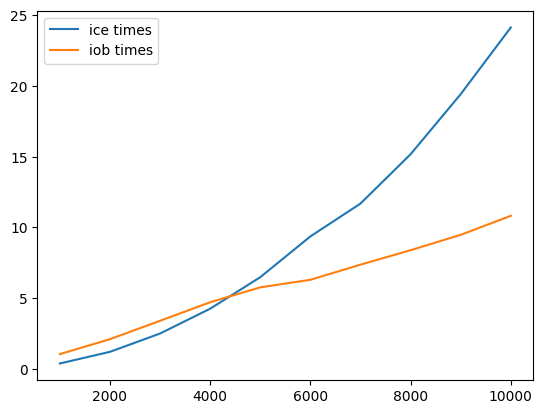

In [8]:
plt.plot(subsets, ice_times, label = "ice times")
plt.plot(subsets, iob_times, label = "iob times")
plt.legend()
plt.show()


We observe that ice has O(n^2) or something, while iob has O(n). Hence, we will working on getting ice to O(n) as well. 

### Batch Size Optimization

Find the batch size that gives the best time, and compare with original performance.

In [9]:
batch_sizes = range(576, 5761, 576)

new_ice_times = []
original_ice_time = [ice_times[-1]] * len(batch_sizes)
total_samples = subsets[-1]

for batch_size in batch_sizes:
    print("Testing for batch size ", batch_size)
    start_time = time.time()
    api.add_insulin_counteraction_effect_to_df_new(user_data.head(total_samples).copy(), basal_shed, isf, cr, insulin_type, batch_size=batch_size)
    new_ice_times += [time.time() - start_time]


Testing for batch size  576
Testing for batch size  1152
Testing for batch size  1728
Testing for batch size  2304
Testing for batch size  2880
Testing for batch size  3456
Testing for batch size  4032
Testing for batch size  4608
Testing for batch size  5184
Testing for batch size  5760


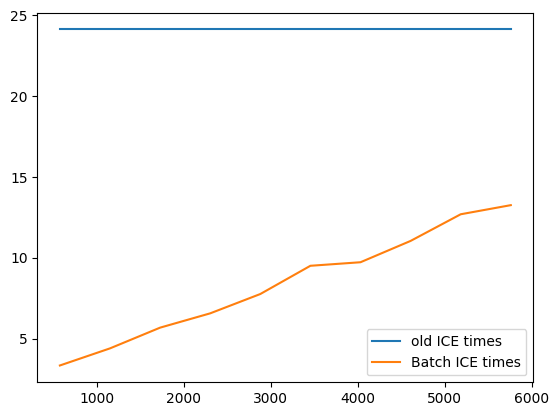

In [10]:
plt.plot(batch_sizes, original_ice_time, label = "old ICE times")
plt.plot(batch_sizes, new_ice_times, label = "Batch ICE times")
plt.legend()
plt.show()

It seems like smaller batch size is generally always better. Lets "zoom in": 

In [11]:
# Overlap is 72, so batch size should at least be 84
batch_sizes = range(84, 1000, 72)
new_ice_times = []
total_samples = 10000

for batch_size in batch_sizes:
    print("Testing for batch size ", batch_size)
    start_time = time.time()
    api.add_insulin_counteraction_effect_to_df_new(user_data.head(total_samples).copy(), basal_shed, isf, cr, insulin_type, batch_size=batch_size)
    new_ice_times += [time.time() - start_time]

Testing for batch size  84
Testing for batch size  156
Testing for batch size  228
Testing for batch size  300
Testing for batch size  372
Testing for batch size  444
Testing for batch size  516
Testing for batch size  588
Testing for batch size  660
Testing for batch size  732
Testing for batch size  804
Testing for batch size  876
Testing for batch size  948


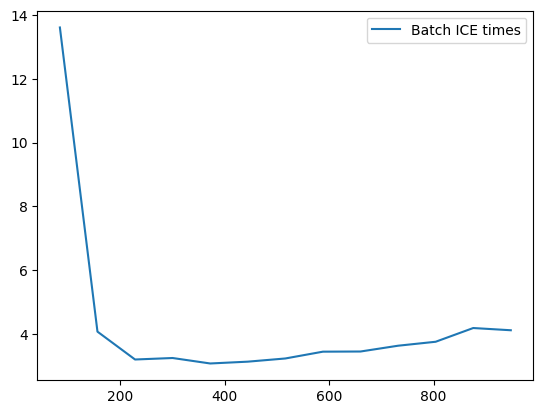

In [12]:
plt.plot(batch_sizes, new_ice_times, label = "Batch ICE times")
plt.legend()
plt.show()

Too low batch size gives an overhead because we have to compute with an overlap. From this graph it looks like a batch size of 400 steps (1-2 days) is preffered.

In [13]:
# Is there any difference when the total samples increases? 
# Overlap is 72, so batch size should at least be 84
batch_sizes = range(84, 1000, 72)
new_ice_times = []

# Lets try with more total samples --> 30000 --> 100 days
total_samples = 30000

for batch_size in batch_sizes:
    print("Testing for batch size ", batch_size)
    start_time = time.time()
    api.add_insulin_counteraction_effect_to_df_new(user_data.head(total_samples).copy(), basal_shed, isf, cr, insulin_type, batch_size=batch_size)
    new_ice_times += [time.time() - start_time]

Testing for batch size  84
Testing for batch size  156
Testing for batch size  228
Testing for batch size  300
Testing for batch size  372
Testing for batch size  444
Testing for batch size  516
Testing for batch size  588
Testing for batch size  660
Testing for batch size  732
Testing for batch size  804
Testing for batch size  876
Testing for batch size  948


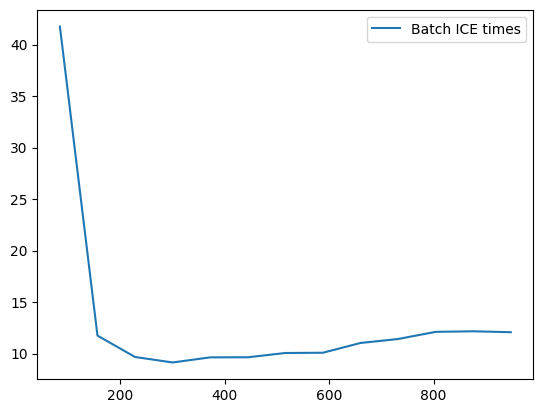

In [14]:
plt.plot(batch_sizes, new_ice_times, label = "Batch ICE times")
plt.legend()
plt.show()

Result is similar, lowest point around 300 steps. 

### Testing the new ICE computation with "optimal" batch size, compared to IOB

In [20]:
ice_times = []
ice_times_old = []
iob_times = []
subsets = range(1000, 10001, 1000)  # start, end, interval. up to 10 000 samples --> 35 days
batch_size = 300

for n in subsets:
    print("Testing for ", n)
    start_time = time.time()
    api.add_insulin_counteraction_effect_to_df_new(user_data.head(n).copy(), basal_shed, isf, cr, insulin_type, batch_size=300)
    ice_times += [time.time() - start_time]
    
    start_time = time.time()
    api.add_insulin_counteraction_effect_to_df(user_data.head(n).copy(), basal_shed, isf, cr, insulin_type)
    ice_times_old += [time.time() - start_time]

    start_time = time.time()
    api.add_insulin_on_board_to_df(user_data.head(n).copy(), basal_shed, isf, cr, insulin_type)
    iob_times += [time.time() - start_time]


Testing for  1000
Testing for  2000
Testing for  3000
Testing for  4000
Testing for  5000
Testing for  6000
Testing for  7000
Testing for  8000
Testing for  9000
Testing for  10000


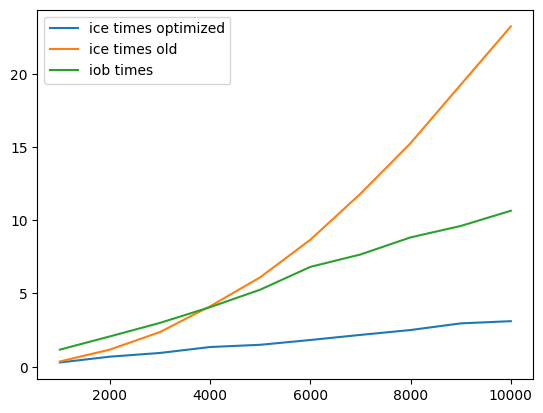

In [21]:
plt.plot(subsets, ice_times, label = "ice times optimized")
plt.plot(subsets, ice_times_old, label = "ice times old")
plt.plot(subsets, iob_times, label = "iob times")
plt.legend()
plt.show()

We observe that the ice went from being the bottleneck, to having linear performance time and being significantly faster than iob. 

15 sec for 10 000 samples (35 days)
--> 150 sec for 100 000 sampels (1 year)
--> 450 sec = 7.5 min for subjects with 3 years of data 

Before optimization, 3 years of data took around 5 hours to process.